## Data cleaning, transdiagnostic factor derivation, and model-free analyses

### Setup

**Import Python dependencies**

In [1]:
import pandas as pd
import joblib, os, rpy2

os.chdir('..')
    # run initially as cd will be the notebook folder otherwise
%load_ext rpy2.ipython
    # warnings about 'quartz' on Windows can be safely ignored.

pal = ["#ffc9b5", "#648767", "#b1ddf1", "#95a7ce", "#987284", "#3d5a80"]
light_pal = ["#ffc9b5", "#b1ddf1", "#987284"]

c:\users\qderc\appdata\local\programs\python\python39\lib\site-packages\rpy2\robjects\packages.py:366: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [2]:
%%R
devtools::load_all()

i Loading pstpipeline


### Import and clean raw data

In [5]:
# %%R
# single <- pstpipeline::import_single(
#     system.file("example_res_single.txt", package = "pstpipeline"), 
#     plot = TRUE, add_sex= TRUE
# )
# multiple <- pstpipeline::import_multiple(
#     system.file("example_res_multiple.txt", package = "pstpipeline"), 
#     separate = FALSE, indiv = TRUE
# )

# all_res_split <- pstpipeline::import_multiple(
#     "data-raw/all_995_complete.txt", add_sex = TRUE
# )
# # this is slow (the .txt file is ~900MB) so not worth doing each time, just here for clarity
# # error about incomplete datasets is more for development, refers to 1 or 2 individuals who didn't finish the task

# save(all_res_split, file = "data/all_res_split.RData")

### Calculate factor scores using model fit previously

**Write and load questionnaire data, and import classifier**

In [3]:
%%R
data(pstpipeline::all_res_split)
# readr::write_csv(
#     dplyr::bind_rows(
#      all_res_split$non_distanced$gillan_questions,
#       all_res_split$distanced$gillan_questions
#     ),
#     "outputs/factor_prediction/questionnaire_subset_all_935.csv",
#      progress = FALSE
# );

In [4]:
questionnaire_likert = pd.read_csv(
    'outputs/factor_prediction/questionnaire_subset_all_935.csv'
)
clf = joblib.load('outputs/factor_prediction/gillan_classifier_78.pkl')

**Predict factor scores in all participants**

In [5]:
factor_score_pred = clf.predict(questionnaire_likert.iloc[:, 1:])
factor_score_pred = pd.DataFrame(
    factor_score_pred, columns = ['AD', 'Compul', 'SW']
)
factor_score_pred.loc[:, 'subjID'] = questionnaire_likert['subjID'].values

factor_score_pred.head()
# factor_score_pred.to_csv(
#     'outputs/factor_prediction/all_935_predicted_factor_scores.csv'
# )

,AD,Compul,SW,subjID
0,2.433235,2.530141,2.251934,5b2a2d855b5c0900018b0bf5
1,3.984658,3.717348,1.664801,5ee93e0226f9f0167b877dbe
2,1.960317,1.586168,1.295876,5f5121371ed01f30b8051b73
3,3.512113,2.449905,1.889159,5f22f8d8e7195104928f837f
4,3.471570,3.412705,1.413577,5ef20e5fa9ac1301228a263a


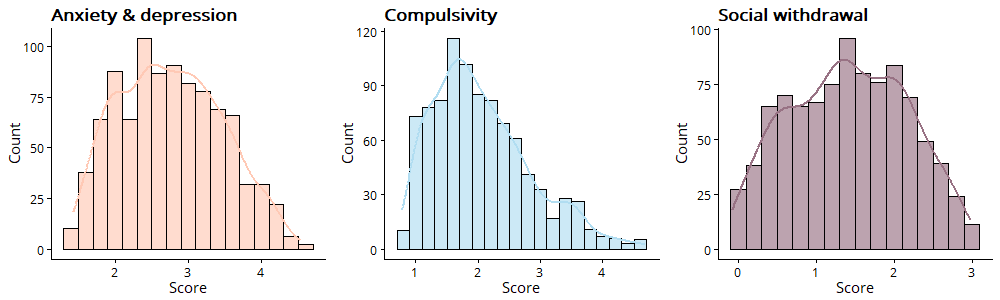

In [6]:
%%R -i factor_score_pred -i light_pal -w 10 -h 3 --units in -r 100

factors = names(factor_score_pred[,1:3])
factor_names = c('Anxiety & depression', 'Compulsivity', 'Social withdrawal')

pstpipeline::plot_factors(
    factor_score_pred, plot_type = "factor_hist", colnames = factors, 
    titles = factor_names, pal = light_pal, font_size = 11, font = "Open Sans"
)

# ggplot2::ggsave('notebooks/plots/all_935_factor_scores.png', device = "png")

**How do these distributions compare to those originally obtained by [Gillan et al (2016)](https://elifesciences.org/articles/11305)?**

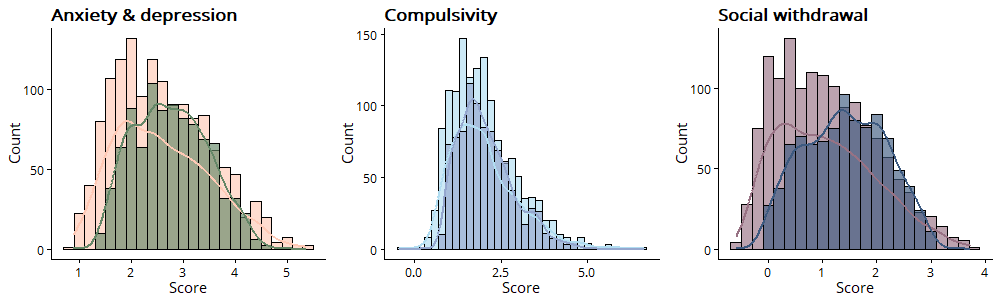

In [7]:
%%R -i factor_score_pred -i pal -w 10 -h 3 --units in -r 100

factor_scores <- factor_score_pred %>%
    dplyr::mutate(dataset = "Our data")
    
all_factor_scores <- read.csv('data-raw/gillan_scores.csv')[-1] %>%
    dplyr::rename(Compul = CIT) %>%
    dplyr::mutate(dataset = "Gillan et al., 2016") %>%
    dplyr::bind_rows(factor_scores)

pstpipeline::plot_factors(
    all_factor_scores, plot_type = "factor_hist", factors, factor_names, 
    pal = pal, group = "dataset", font_size = 11, font = "Open Sans"
)

# ggplot2::ggsave(
#     'notebooks/plots/gillan2016_factor_scores.png', device = "png"
# )

Scores for the "Compulsivity" factor seem relatively close to that seen in the study by [Gillan et al (2016)](https://elifesciences.org/articles/11305), while scores for the "Anxiety/Depression" factor are slightly higher. This may be explained by our aim to actively recruit a sample which included a similar proportion of individuals reporting a psychiatric diagnosis (past or present) to the UK population. Scores for the "Social Withdrawal" were notably higher than those seen in the original dataset. This may be partly confounded by the fact that data collection took place in April-May 2021, when the UK was not yet fully out of lockdown restrictions, as it was predicted primarily from questions on the Liebowitz Social Anxiety Scale (LSAS), which asks participants to rate their fear and avoidance of various social situations (e.g., "Going to a party"). Though participants were asked to try to imagine their feelings towards these situations independently of restrictions, this was likely difficult for many.

### Plot model-free training and test data

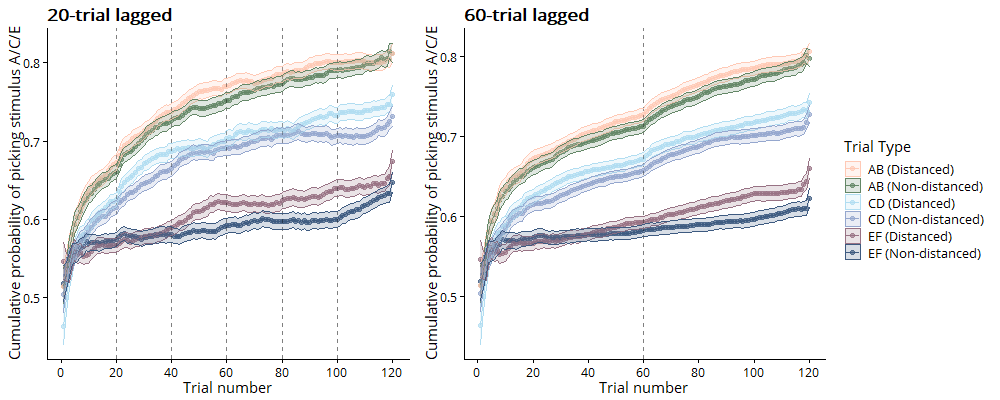

In [19]:
%%R -w 10 -h 4 --units in -r 100

training_plots <- pstpipeline::plot_import(
    all_res_split, types = "train", plt.train = list(c(20, 60)), 
    grp_compare = "distanced", grp_names = c("Non-distanced", "Distanced"), 
    font = "Open Sans", font_size = 11
)

legend <- cowplot::get_legend(
  # create some space to the left of the legend
  training_plots[[1]] + ggplot2::theme(
      legend.box.margin = ggplot2::margin(0, 0, 0, 8)
  )
)

cowplot::plot_grid(
    training_plots[[1]] + ggplot2::theme(legend.position="none"), 
    training_plots[[2]] + ggplot2::theme(legend.position="none"), 
    legend, nrow = 1, rel_widths = c(1,1,.4) 
)

# ggplot2::ggsave('notebooks/plots/training_plots_20-60.png', device = "png")

On average the distanced group perform marginally better by the end of the task, particularly in the harder pairs (CD and EF). Does this follow to the test phase?

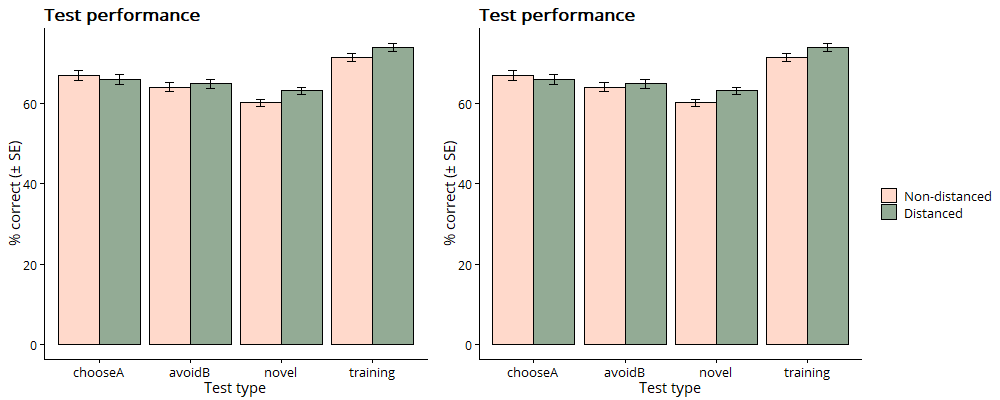

In [22]:
%%R -w 10 -h 4 --units in -r 100

test_plot_grp <- pstpipeline::plot_import(
    all_res_split, types = "test", grp_compare = "distanced", 
    grp_names = c("Non-distanced", "Distanced"), 
    font = "Open Sans", font_size = 11
)
test_plot_ntr <-  pstpipeline::plot_import(
    all_res_split, types = "test", 
    plt.test = list(c("training", "novel"), "individual"), 
    grp_compare = "distanced", grp_names = c("Non-distanced", "Distanced"), 
    font = "Open Sans", font_size = 11)

legend <- cowplot::get_legend(
  # create some space to the left of the legend
  test_plot_grp + ggplot2::theme(
      legend.box.margin = ggplot2::margin(0, 0, 0, 8)
  )
)

cowplot::plot_grid(
    test_plot_grp + ggplot2::theme(legend.position="none"), 
    test_plot_grp + ggplot2::theme(legend.position="none"), 
    legend, nrow = 1, rel_widths = c(1,1,.3) 
)

# ggplot2::ggsave('notebooks/plots/test_plots_nov-train.png', device = "png")

Indeed, the distanced group appear to do better in both the training and novel pairs overall. This increase in performance appears driven by the novel and training pairs which include the harder stimuli - "C" or "E".